In [84]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, StaleElementReferenceException, ElementClickInterceptedException
from selenium.webdriver.common.action_chains import ActionChains
import time
import random
from collections import deque # Efficiëntere queue dan een lijst
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd

In [2]:
# --- Configuratie ---
INFINITE_CRAFT_URL = "https://neal.fun/infinite-craft/"
INITIAL_ELEMENTS = ["Water", "Fire", "Wind", "Earth"]
WAIT_TIMEOUT = 0.2  # Seconden wachttijd voor elementen
ACTION_DELAY = 0 # Kleine pauze tussen acties
COMBINATION_DELAY = 0.5 # Wachttijd na een combinatie om resultaat te zien

In [3]:
# --- Hoofdlogica ---
options = uc.ChromeOptions()
#options.add_argument("--headless") # Headless kan problemen geven met detectie/interactie

# Specify your installed Chrome major version (135 in this case)
chrome_major_version = 135

driver = uc.Chrome(options=options, use_subprocess=True, version_main=chrome_major_version)

driver.get(INFINITE_CRAFT_URL)

In [4]:
# //*[@id="sidebar"]/div[3]/div elementen in de sidebar

# //*[@id="instances"] Elements in the game
# //*[@id="instances-top"] element die je vast hebt
# //*[@id="instances instance-hover"] element waar je met over gaat
# //*[@id="#instance instance-pinwheel"] nieuwe element die je hebt gemaakt

In [ ]:
elements_sidebar = driver.find_elements(By.XPATH, '/html/body/div[1]/div/div/div/div[1]/div[3]/div/div[1]')
# Maak een lijst van elementen game_stake["elements_sidebar"] in de sidebar elke \n is een nieuwe regel
elements_sidebar_text_list = elements_sidebar[0].text.split("\n")
for i in range(len(elements_sidebar_text_list)):
    # kijk of de eerste letter een letter is haal hem anders weg
    i = 0
    while not elements_sidebar_text_list[i][0].isalpha():
        elements_sidebar_text_list[i] = elements_sidebar_text_list[i][1:]
        i = i + 1
        if i >= len(elements_sidebar_text_list[i]):
            break

print("Sidebar elementen:", elements_sidebar_text_list)

Sidebar elementen: ['Water', 'Fire', 'Wind', 'Earth', 'Wave', 'Lake', 'Steam', 'Mud', 'Beach', 'Volcano', 'Lava', 'Stone', 'Mountain', 'Sand', 'Tsunami', 'Tornado', 'Destruction', 'Glass', 'Eruption', 'Clay', 'Pottery', 'Vase', 'Urn', 'Dust', 'Brick', 'Kiln', 'Ocean', 'Sea', 'Plant', 'Swamp', 'Rock', 'Obsidian', 'Mist', 'Blade', 'Sword', 'Axe', 'Longsword', 'Battleaxe', 'Flaming Battleaxe']


In [ ]:
elements_active = driver.find_elements(By.XPATH, '//*[@id="instances"]/*')

elements_active_text_list = []

for i in range(len(elements_active)):
    active_el = elements_active[i].text
    # haal alles tot en met \n weg
    elements_active_text_list.append(active_el.split("\n")[1])
print("Actieve elementen:", elements_active_text_list)

Actieve elementen: ['Tornado', 'Water', 'Flaming Battleaxe']


In [72]:
def get_game_state(driver):
    elements_active = driver.find_elements(By.XPATH, '//*[@id="instances"]/*')
    elements_sidebar = driver.find_elements(By.XPATH, '/html/body/div[1]/div/div/div/div[1]/div[3]/div/div[1]')
    element_hand = driver.find_element(By.XPATH, '//*[@id="instances-top"]')
    try:
        element_hover = driver.find_element(By.XPATH, '//*[@id="instances instance-hover"]')
    except NoSuchElementException:
        element_hover = None
    try:
       element_new = driver.find_element(By.XPATH, '//*[@id="instances instance-pinwheel"]')
    except NoSuchElementException:
        element_new = None

    elements_sidebar_text_list = elements_sidebar[0].text.split("\n")
    for i in range(len(elements_sidebar_text_list)):
        # kijk of de eerste letter een letter is haal hem anders weg
        z = 0
        while not elements_sidebar_text_list[i][0].isalpha():
            elements_sidebar_text_list[i] = elements_sidebar_text_list[i][1:]
            z = z + 1
            if z >= len(elements_sidebar_text_list[i]):
                break
    
    try:
        elements_active_text_list = []
        for i in range(len(elements_active)):
            active_el = elements_active[i].text
            # haal alles tot en met \n weg
            elements_active_text_list.append(active_el.split("\n")[1])

    except StaleElementReferenceException or ElementClickInterceptedException or NoSuchElementException:
        elements_active_text_list = []

    return {"elements_active":elements_active,
            "elements_active_text_list":elements_active_text_list,
            "elements_sidebar":elements_sidebar,
            "elements_sidebar_text_list":elements_sidebar_text_list,
            "element_hand":element_hand,
            "element_hover":element_hover,
            "element_new":element_new}

In [73]:
def get_element_from_sidebar(driver, element_name):
    """Zoekt een specifiek element op naam in de sidebar."""
    # XPath is vaak robuuster voor tekstinhoud, normaliseert spaties
    xpath = f"//div[@class='items-inner']//div[@class='item' and normalize-space(text())='{element_name}']"

    element = WebDriverWait(driver, WAIT_TIMEOUT).until(
        EC.presence_of_element_located((By.XPATH, xpath))
        )
    return element

def get_element_active(driver, element_name):
    """Zoekt alle specifieke elementen op naam in de actieve elementen en retourneert ze als een lijst."""
    # xpath targets the span element containing the text, e.g., <span class="instance-text">Fire</span>
    # within the main game area <div id="instances">
    try:
        xpath = f"//div[@id='instances']//span[@class='instance-text' and text()='{element_name}']"
    
        # Wait for all elements matching the xpath to be present
        elements = WebDriverWait(driver, WAIT_TIMEOUT).until(
            EC.presence_of_all_elements_located((By.XPATH, xpath))
            )
        return elements
    except TimeoutException:
        print(f"Element '{element_name}' niet gevonden in actieve elementen.")
        return []

# print("Zoek naar elementen in de sidebar...")
# element = get_element_from_sidebar(driver, "Wind")
# print("Element gevonden:", element.text)
# print("Zoek naar elementen in de actieve elementen...")
# element = get_element_active(driver, "Wind")
# for elem in element:
#     print("Element gevonden:", elem.text)

In [74]:
def combine_elements(driver,element1_naam, element2_naam, timedelay=0.5):
    """Combineer twee elementen in het spel en retourneer het recept"""
    # Zet element 1 in speelbord
    item1_html = get_element_from_sidebar(driver, element1_naam) # Het element dat je wilt combineren
    actions.click(item1_html).perform() # Klik op het eerste element in de sidebar

    #Sla de huidige game state op
    game_state_before = get_game_state(driver)

    #Vind html van element 1
    item1_html_lijst = get_element_active(driver, element1_naam) # Het element dat je wilt combineren
    item1_html_eerstegevonden = item1_html_lijst[0] # Het eerste element dat je wilt combineren

    #Vind element 2 in de sidebar
    item2_html = get_element_from_sidebar(driver, element2_naam)

    #Pak element 2 van de sidebar en sleep het op element 1
    actions.drag_and_drop(item2_html,item1_html_eerstegevonden).perform()
    time.sleep(timedelay) # Wacht op de combinatie om te voltooien

    #Sla game state na op
    game_state_after = get_game_state(driver)

    # Maak een kopie van de lijsten om te bewerken
    before_list1 = game_state_before["elements_active_text_list"]
    before_list1.append(element2_naam)
    after_list1 = game_state_after["elements_active_text_list"]
    before_list2 = before_list1.copy()
    after_list2 =  after_list1.copy()

    for element in before_list1:
        if element in after_list1:
            after_list1.remove(element)

    for element in after_list2:
        if element in before_list2:
            before_list2.remove(element)

    return [before_list2, after_list1]

In [75]:
def clear_canvas(driver):
    """Klikt op de 'Clear' knop om het speelveld leeg te maken."""
        # Zoek de clear knop (selector kan veranderen!)
        # Mogelijke selectors: img[src*='clear.svg'], een div met een specifieke class of id
    clear_button_xpath = "//img[contains(@class, 'clear')]" # Probeer deze XPath
    clear_button = WebDriverWait(driver, WAIT_TIMEOUT).until(
        EC.element_to_be_clickable((By.XPATH, clear_button_xpath))
    )
    print("Canvas leegmaken...")
        # Soms wordt de klik geblokkeerd, probeer met JavaScript
    driver.execute_script("arguments[0].click();", clear_button)
        # Wacht op de bevestigingsdialog
    time.sleep(ACTION_DELAY)
        # Zoek en klik op de 'Yes' knop (selector kan veranderen!)
        # Mogelijke selectors: button met text 'Yes', specifieke class
    yes_button_xpath = "//button[contains(@class, 'action-btn') and contains(text(), 'Yes')]"
    yes_button = WebDriverWait(driver, WAIT_TIMEOUT).until(
            EC.element_to_be_clickable((By.XPATH, yes_button_xpath))
        )
    driver.execute_script("arguments[0].click();", yes_button)
    print("Canvas leeggemaakt.")
    time.sleep(ACTION_DELAY) # Geef tijd om te verwerken
    return True

In [76]:
def hard_combine_elements(driver,element1_naam, element2_naam, timedelay=0.5, hard_these_elements=False):
    """Combineer twee elementen in het spel en retourneer het recept maar kan ook met zekerheid cobinaties met None vinden"""
    if hard_these_elements:
        clear_canvas(driver)
        recept = combine_elements(driver,element1_naam, element2_naam, timedelay=timedelay)
        if recept == [[], []]:
            print(f"Geen nieuwe elementen gevonden bij het combineren van {element1_naam} en {element2_naam}.")
            return [[element1_naam,element2_naam], [None]]
        else:
            return recept
    else:
        recept = combine_elements(driver,element1_naam, element2_naam, timedelay=timedelay)
        if recept == [[], []]:
            print(f"Geen nieuwe elementen gevonden bij het combineren van {element1_naam} en {element2_naam}.")
            print("Probeer opnieuw... met clear_canvas")
            clear_canvas(driver)
            recept = combine_elements(driver,element1_naam, element2_naam, timedelay=timedelay)
            if recept == [[], []]:
                print(f"Geen nieuwe elementen gevonden bij het combineren van {element1_naam} en {element2_naam}.")
                return [[element1_naam,element2_naam], [None]]
            else:
                return recept
        else:
            print(f"Nieuwe elementen gevonden bij het combineren van {element1_naam} en {element2_naam}: {recept[1]}")
            return recept

In [77]:
actions = ActionChains(driver)
nieuw_element = combine_elements(driver,"Water", "Wind", COMBINATION_DELAY)
print("Nieuw element gemaakt:", nieuw_element)

Nieuw element gemaakt: [['Water', 'Wind'], ['Wave']]


In [78]:
actions = ActionChains(driver)
nieuw_element = hard_combine_elements(driver,"Wind","Wind", COMBINATION_DELAY, hard_these_elements=True)
print("Nieuw element gemaakt:", nieuw_element)

Canvas leegmaken...
Canvas leeggemaakt.
Nieuw element gemaakt: [['Wind', 'Wind'], ['Tornado']]


In [79]:
game_state =  get_game_state(driver)
alle_bekende_elementen = game_state["elements_sidebar_text_list"]
recipes = {}  # Dictionary om recepten op te slaan

#ik wil een lijst maken van combinaties van elementen die nog niet zijn geprobeerd
combinations = []
for i in range(len(alle_bekende_elementen)):
    for j in range(i, len(alle_bekende_elementen)):
        if (alle_bekende_elementen[i], alle_bekende_elementen[j]) not in recipes:
            combinations.append((alle_bekende_elementen[i], alle_bekende_elementen[j]))

print("Combinaties:", combinations)

Combinaties: [('Water', 'Water'), ('Water', 'Fire'), ('Water', 'Wind'), ('Water', 'Earth'), ('Water', 'Wave'), ('Water', 'Lake'), ('Water', 'Steam'), ('Water', 'Mud'), ('Water', 'Beach'), ('Water', 'Volcano'), ('Water', 'Lava'), ('Water', 'Stone'), ('Water', 'Mountain'), ('Water', 'Sand'), ('Water', 'Tsunami'), ('Water', 'Tornado'), ('Water', 'Destruction'), ('Water', 'Glass'), ('Water', 'Eruption'), ('Water', 'Clay'), ('Water', 'Pottery'), ('Water', 'Vase'), ('Water', 'Urn'), ('Water', 'Dust'), ('Water', 'Brick'), ('Water', 'Kiln'), ('Water', 'Ocean'), ('Water', 'Sea'), ('Water', 'Plant'), ('Water', 'Swamp'), ('Water', 'Rock'), ('Water', 'Obsidian'), ('Water', 'Mist'), ('Water', 'Blade'), ('Water', 'Sword'), ('Water', 'Axe'), ('Water', 'Longsword'), ('Water', 'Battleaxe'), ('Water', 'Flaming Battleaxe'), ('Fire', 'Fire'), ('Fire', 'Wind'), ('Fire', 'Earth'), ('Fire', 'Wave'), ('Fire', 'Lake'), ('Fire', 'Steam'), ('Fire', 'Mud'), ('Fire', 'Beach'), ('Fire', 'Volcano'), ('Fire', 'Lava')

In [80]:
actions = ActionChains(driver)
for element1, element2 in combinations:
    try:
        nieuw_element = hard_combine_elements(driver,element1, element2, COMBINATION_DELAY)
        # Voeg het nieuwe element toe aan de receptenlijst
        if len(nieuw_element[0]) == 2:  # Ensure nieuw_element[0] has two elements
            recipes[(nieuw_element[0][0], nieuw_element[0][1])] = nieuw_element[1][0]
    except Exception as e:
        print(f"Fout opgetreden bij het combineren van {element1} en {element2}: {e}")
        continue

Nieuwe elementen gevonden bij het combineren van Water en Water: ['Lake']
Nieuwe elementen gevonden bij het combineren van Water en Fire: ['Steam']
Nieuwe elementen gevonden bij het combineren van Water en Wind: ['Wave']
Nieuwe elementen gevonden bij het combineren van Water en Earth: ['Plant']
Nieuwe elementen gevonden bij het combineren van Water en Wave: ['Tsunami']
Nieuwe elementen gevonden bij het combineren van Water en Lake: ['Ocean']
Nieuwe elementen gevonden bij het combineren van Water en Steam: ['Cloud']
Nieuwe elementen gevonden bij het combineren van Water en Mud: ['Swamp']
Nieuwe elementen gevonden bij het combineren van Water en Beach: ['Ocean']
Nieuwe elementen gevonden bij het combineren van Water en Volcano: ['Lava']
Nieuwe elementen gevonden bij het combineren van Water en Lava: ['Stone']
Nieuwe elementen gevonden bij het combineren van Water en Stone: ['Rock']
Nieuwe elementen gevonden bij het combineren van Water en Mountain: ['Lake']
Nieuwe elementen gevonden bij 

In [81]:
recipes

{('Water', 'Water'): 'Lake',
 ('Water', 'Fire'): 'Steam',
 ('Water', 'Wind'): 'Wave',
 ('Water', 'Earth'): 'Plant',
 ('Water', 'Wave'): 'Tsunami',
 ('Water', 'Lake'): 'Ocean',
 ('Water', 'Steam'): 'Cloud',
 ('Water', 'Mud'): 'Swamp',
 ('Water', 'Beach'): 'Ocean',
 ('Water', 'Volcano'): 'Lava',
 ('Water', 'Lava'): 'Stone',
 ('Water', 'Stone'): 'Rock',
 ('Water', 'Mountain'): 'Lake',
 ('Water', 'Sand'): 'Beach',
 ('Water', 'Tsunami'): 'Ocean',
 ('Water', 'Tornado'): 'Tsunami',
 ('Water', 'Destruction'): 'Tsunami',
 ('Water', 'Glass'): 'Wine',
 ('Water', 'Eruption'): 'Lava',
 ('Water', 'Clay'): 'Pottery',
 ('Water', 'Pottery'): 'Vase',
 ('Water', 'Vase'): 'Flower',
 ('Water', 'Urn'): 'Tear',
 ('Water', 'Dust'): 'Mud',
 ('Water', 'Brick'): 'Glass',
 ('Water', 'Kiln'): 'Glass',
 ('Water', 'Ocean'): 'Fish',
 ('Water', 'Sea'): 'Ocean',
 ('Water', 'Plant'): 'Swamp',
 ('Water', 'Swamp'): 'Marsh',
 ('Fire', 'Fire'): 'Volcano',
 ('Fire', 'Wind'): 'Smoke',
 ('Fire', 'Earth'): 'Lava',
 ('Fire', 'Wa

# Tot hier werkt het

In [85]:
import csv
import os

# Define the folder name
folder_name = 'recipes'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the CSV file path
csv_file_path = os.path.join(folder_name, 'discovered_recipes.csv')

# Write the recipes to the CSV file
try:
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Element1', 'Element2', 'Result']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for (elem1, elem2), result in recipes.items():
            writer.writerow({'Element1': elem1, 'Element2': elem2, 'Result': result})
    print(f"Recipes successfully saved to {csv_file_path}")
except Exception as e:
    print(f"Error writing recipes to CSV: {e}")

Recipes successfully saved to recipes\discovered_recipes.csv


In [86]:
# Load the CSV file into a DataFrame
df = pd.read_csv('recipes/discovered_recipes.csv')
combinations = df.to_numpy().tolist()

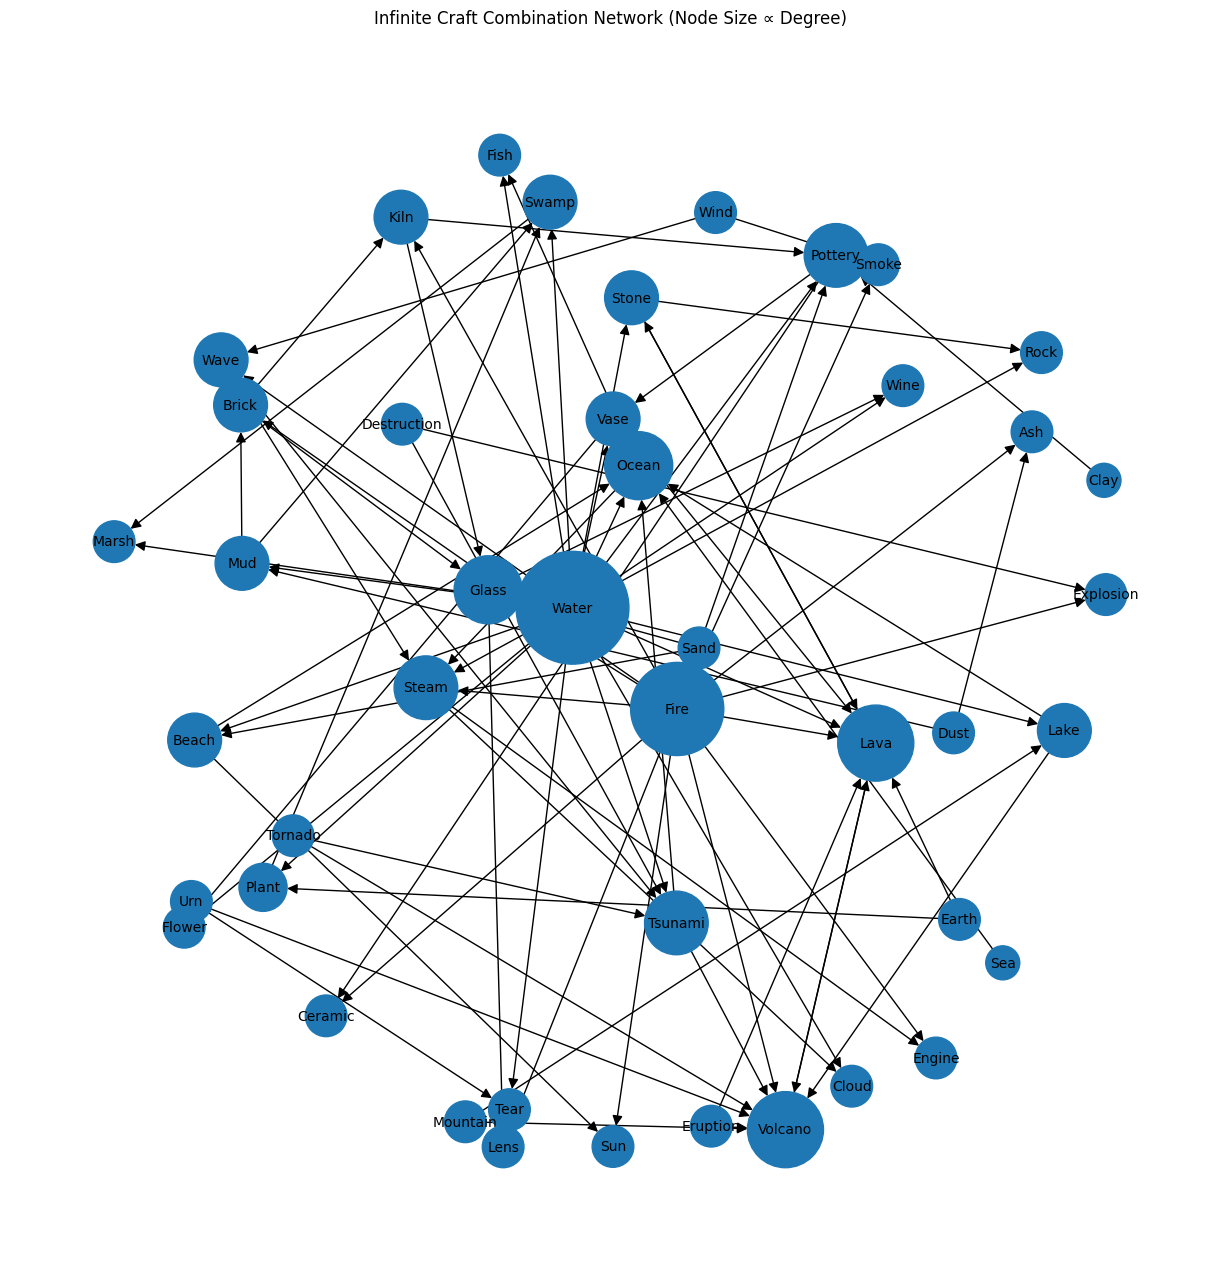

In [88]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame
#df = pd.DataFrame.from_dict(recipes, orient='index', columns=['Element1', 'Element2', 'Result']).reset_index(drop=True)

# Create directed graph
G = nx.DiGraph()
for _, row in df.iterrows():
    e1, e2, result = row['Element1'], row['Element2'], row['Result']
    G.add_node(e1)
    G.add_node(e2)
    G.add_node(result)
    G.add_edge(e1, result)
    G.add_edge(e2, result)

# Compute node sizes based on degree (number of connections)
degrees = dict(G.degree())
# Scale sizes: base size plus multiplier
node_sizes = [300 + degrees[n] * 300 for n in G.nodes()]

# Layout and draw
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1.2, seed=42)
nx.draw(G, pos, with_labels=True, node_size=node_sizes, font_size=10, arrowsize=15)
plt.title("Infinite Craft Combination Network (Node Size ∝ Degree)", pad=20)
plt.axis('off')
plt.show()
